In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.preprocessing import image
from keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten
    
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# randomness consistancy
seed = 101
rng = np.random.RandomState(seed)

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data.head()

,image_names,class
0,11413.jpg,1
1,9863.jpg,1
2,997.jpg,0
3,5950.jpg,0
4,10454.jpg,1


In [5]:
data['class'].value_counts()

1    6174
0    6022
Name: class, dtype: int64

In [6]:
#Accuracy can be a good mesure
from keras.preprocessing.image import load_img, img_to_array, array_to_img

In [7]:
# load images
X = list()
for i in data.image_names:
    img = load_img("images/"+i)
    img = img_to_array(img)
    X.append( img)

In [8]:
#Create an array of Images
X= np.array(X)
X.shape

(12196, 224, 224, 3)

#### Preprocess image
##### scale the pixel value to 0.0 to 1.0 range

In [9]:
X=X/X.max()

#### train test samples

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train,x_valid,y_train,y_valid = train_test_split(X,data['class'],test_size=0.3,random_state=seed)

### Image augmentations

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
image_augments = ImageDataGenerator(
                    width_shift_range = 0.2,
                    horizontal_flip = True,
                    height_shift_range=0.2,
                    vertical_flip=True                    
                 )

#### Model the network

In [14]:
from keras.layers import InputLayer, Dense, Convolution2D, MaxPooling2D

In [15]:
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dropout

In [16]:
model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(Conv2D(filters = 64, kernel_size = (1,1), activation='relu', padding='same'))
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
    
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation='relu', padding='same'))
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation='relu', padding='same'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters = 256, kernel_size = (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters = 256, kernel_size = (3,3), activation='relu', padding='same'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters = 512, kernel_size = (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters = 1024, kernel_size = (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(GlobalAveragePooling2D())

model.add(Dense(units = 2048, activation ='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=1, activation = 'sigmoid'))


model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
__________

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
final_weights_path = 'trial_cnn_model.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_loss', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=30, verbose=1)
]

In [22]:
perf_hist = model.fit_generator(image_augments.flow(x_train, y_train, batch_size=32),epochs=200,validation_data=(x_valid,y_valid), callbacks=callbacks_list, shuffle=False, workers=5, use_multiprocessing=True)

Epoch 1/200
267/267 [==============================] - 97s 363ms/step - loss: 0.2810 - acc: 0.8694 - val_loss: 0.3280 - val_acc: 0.8612

Epoch 00001: val_loss improved from inf to 0.32804, saving model to trial_cnn_model.h5
Epoch 2/200
267/267 [==============================] - 94s 352ms/step - loss: 0.2119 - acc: 0.9099 - val_loss: 0.3181 - val_acc: 0.8560

Epoch 00002: val_loss improved from 0.32804 to 0.31814, saving model to trial_cnn_model.h5
Epoch 3/200
267/267 [==============================] - 94s 354ms/step - loss: 0.2889 - acc: 0.8765 - val_loss: 0.2353 - val_acc: 0.8989

Epoch 00003: val_loss improved from 0.31814 to 0.23529, saving model to trial_cnn_model.h5
Epoch 4/200
267/267 [==============================] - 94s 353ms/step - loss: 0.2647 - acc: 0.8856 - val_loss: 0.2187 - val_acc: 0.9057

Epoch 00004: val_loss improved from 0.23529 to 0.21868, saving model to trial_cnn_model.h5
Epoch 5/200
267/267 [==============================] - 94s 353ms/step - loss: 0.2595 - acc: 

267/267 [==============================] - 94s 353ms/step - loss: 0.1046 - acc: 0.9568 - val_loss: 0.1452 - val_acc: 0.9483

Epoch 00041: val_loss did not improve from 0.12247
Epoch 42/200
267/267 [==============================] - 94s 352ms/step - loss: 0.1055 - acc: 0.9595 - val_loss: 0.1715 - val_acc: 0.9300

Epoch 00042: val_loss did not improve from 0.12247
Epoch 43/200
267/267 [==============================] - 94s 353ms/step - loss: 0.1059 - acc: 0.9588 - val_loss: 0.1429 - val_acc: 0.9453

Epoch 00043: val_loss did not improve from 0.12247
Epoch 44/200
267/267 [==============================] - 95s 354ms/step - loss: 0.0994 - acc: 0.9603 - val_loss: 0.4943 - val_acc: 0.7622

Epoch 00044: val_loss did not improve from 0.12247
Epoch 45/200
267/267 [==============================] - 94s 353ms/step - loss: 0.1000 - acc: 0.9620 - val_loss: 0.1196 - val_acc: 0.9530

Epoch 00045: val_loss improved from 0.12247 to 0.11962, saving model to trial_cnn_model.h5
Epoch 46/200
267/267 [======


Epoch 00082: val_loss did not improve from 0.09808
Epoch 83/200
267/267 [==============================] - 94s 353ms/step - loss: 0.0562 - acc: 0.9802 - val_loss: 0.1138 - val_acc: 0.9582

Epoch 00083: val_loss did not improve from 0.09808
Epoch 84/200
267/267 [==============================] - 94s 352ms/step - loss: 0.0605 - acc: 0.9774 - val_loss: 0.1340 - val_acc: 0.9519

Epoch 00084: val_loss did not improve from 0.09808
Epoch 85/200
267/267 [==============================] - 94s 353ms/step - loss: 0.0575 - acc: 0.9777 - val_loss: 0.1366 - val_acc: 0.9538

Epoch 00085: val_loss did not improve from 0.09808
Epoch 86/200
267/267 [==============================] - 94s 353ms/step - loss: 0.0514 - acc: 0.9802 - val_loss: 0.1173 - val_acc: 0.9571

Epoch 00086: val_loss did not improve from 0.09808
Epoch 87/200
267/267 [==============================] - 94s 353ms/step - loss: 0.0543 - acc: 0.9793 - val_loss: 0.1329 - val_acc: 0.9486

Epoch 00087: val_loss did not improve from 0.09808
Epo

In [23]:
import matplotlib.pyplot as plt

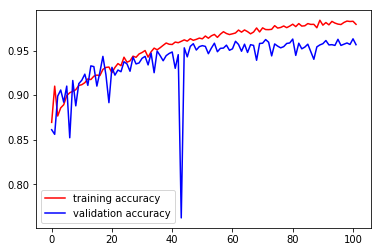

In [24]:
plt.plot(perf_hist.history['acc'], 'r')
plt.plot(perf_hist.history['val_acc'], 'b')
plt.legend({'training accuracy': 'r', 'validation accuracy':'b'})
plt.show()

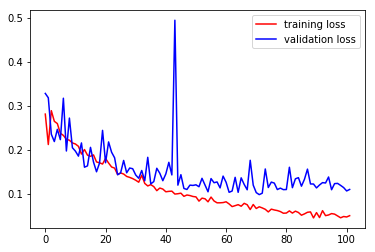

In [25]:

plt.plot(perf_hist.history['loss'], 'r')
plt.plot(perf_hist.history['val_loss'], 'b')
plt.legend({'training loss': 'r', 'validation loss':'b'})
plt.show()

In [26]:
#load test data
test_data = pd.read_csv("test.csv")

In [27]:
test_data.head()

,image_names
0,5603.jpg
1,1286.jpg
2,9815.jpg
3,8865.jpg
4,9306.jpg


In [28]:
test_images = list()
for i in test_data.image_names:
    img = load_img("images/"+i)
    img = img_to_array(img)
    test_images.append( img)
test_images=np.array(test_images)

In [29]:
test_images.shape

(5227, 224, 224, 3)

In [ ]:
test_images = test_images/test_images.max()

In [ ]:
predictions = model.predict_classes(test_images)

In [ ]:
result = pd.DataFrame(index=None)

In [ ]:
result['image_names']=test_data['image_names']
result['class']=predictions

In [ ]:
result.to_csv(path_or_buf='result.csv',index=False)